In [1]:
from BankSim import *
from timerep import *
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
# First let's create lists of names of USA states and most of European Union countries (ones that should be safe)
USA_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
              "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
              "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
              "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
              "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma",
              "Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee",
              "Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
EU_countries = ["Belgium","France","Germany","Italy","Luxembourg","Netherlands","Denmark","Ireland",
             "United Kingdom","Portugal","Spain","Austria","Finland","Sweden","Czech Republic",
             "Estonia","Hungary","Latvia","Lithuania","Poland","Slovakia","Slovenia","Bulgaria","Romania","Croatia"]

In [3]:
# enum class for transaction type
# this transaction type enum isn't used internally while simulating but is used after the transactions 
# have been generated. They get transformed to just these 2 transaction types.
class MyTransactionType(Enum):
    """Enumeration class for transaction types.
    
    * DEBIT - all operations that make the balance lower on the account
    * CREDIT - all operations that make the balance higher on the account
    """
    DEBIT = 1
    CREDIT = 2
    
    def __str__(self):
        """Convert enum type into string."""
        return str(self.name)

In [4]:
# reimplementation of the Transaction class from the simulator framework
# we added ID of transaction, country and bank of sender and receiver
# Transaction class is used for creating a record of an executed transaction. 
# From these transactions we then generate a DataFrame.
class MyTransaction(Transaction):
    """
    Class which represents a single transaction, which should equal one row in a dataframe.
    """
    ID = 1

    def __init__(self,sender, receiver, tr_type, amount, timestamp, step_count):
        super().__init__(sender,receiver,tr_type,amount,timestamp,step_count)
        self.sender_country = sender.agent_country
        self.receiver_country = receiver.agent_country
        self.sender_bank = sender.bank_name
        self.receiver_bank = receiver.bank_name

In [5]:
# reimplementation of the RandomOperation class
# we needed to add cutting the float number to just 2 decimal places
# also needed to add MyTransaction instead of Transaction and use the function for updating agents' balances
class MyRandomOperation(RandomOperation):
    def execute(self,timestamp,stepcount):
        transactions=[]
        assert len(self.tr_type) == len(self.friends_probabilities) == len(self.friends_distributions_of_amount)
        for index,receiver in enumerate(self.friends_list):
            if random.random() <= self.friends_probabilities[index]:
                #probability requirement is satisfied
                amount=self.friends_distributions_of_amount[index].sample()
                amount = amount_2decimal(amount)
                #create transaction
                t=MyTransaction(self.sender,receiver,self.tr_type[index],amount,timestamp,stepcount)
                update_agents_balances(t.sender,t.receiver,t.tr_type,t.amount)
                t.balance_after_posted_sender = t.sender.balance
                t.balance_after_posted_receiver = t.receiver.balance
#                 t.process_label = self.process_labels[index]
                transactions.append(t)
        return transactions

In [6]:
# reimplementation of ScheduledOperation because of the same reason as RandomOperation -- float to 2 decimal places
# and updating agents' balances
class MyScheduledOperation(ScheduledOperation):
    def execute(self,timestamp,stepcount):
        transactions=[] #only for providing compatibility
        if self.start <= timestamp <= self.end:
            # we are in the interval for which the operation should be executable
            # we will probably need to turn the stepcount into a datetime
            if self.time_distribution.evaluate(timestamp) == True: # the operation should be executed on this stepcount
                amount=self.amount_distribution.sample()
                amount = amount_2decimal(amount)
                t=MyTransaction(self.sender,self.receiver,self.tr_type,amount,timestamp,stepcount)
                update_agents_balances(t.sender,t.receiver,t.tr_type,t.amount)
                t.balance_after_posted_sender = t.sender.balance
                t.balance_after_posted_receiver = t.receiver.balance
                transactions.append(t)
        return transactions # return list of zero or one transaction(s)

In [7]:
# reimplementation of Distribution because we wanted to add random state as None
class MyDistribution(Distribution):
    def sample(self,size=1):
        if size == 1:
            return self.random_var.rvs(random_state=None)
        elif size>1:
            return self.random_var.rvs(size=size,random_state=None)
        else:
            raise ValueError("Wrong value for parameter: size.")

In [8]:
# class for transforming Connections to Debit Operations of HighMark LLC agent
class DebitOps(ConnectionToOperationTransformer):
    def transform(self,connections):
        # create friends list for every agent
        agents={}
        for conn in connections:
            if conn.origin not in agents:
                agents[conn.origin]=[]
        for conn in connections:
            if conn.target not in agents[conn.origin]:
                agents[conn.origin].append(conn.target)
        
        for agent,conns in agents.items():
            # probability of executing the operation
            friends_probabilities=np.random.choice([1/125,1/250],p=[0.5,0.5],replace=True,size=len(conns))
            friends_list=conns
            
            # probability distribution for the transaction amount
            scipy_distr=scipy.stats.beta(a=1, b=9, loc=1500, scale=30000)
            d=MyDistribution(scipy_distr)
            
            friends_distributions_of_amount=[d for _ in range(len(conns))]
            trtypes = [TransactionType.TRANSFER for _ in range(len(conns))]
            rop=MyRandomOperation(agent,trtypes,friends_distributions_of_amount,friends_list,friends_probabilities)
            agent.add_operation(rop)

# class for transforming Connections to Credit Operations that go to HighMark LLC Agent (performed by other agents)
class CreditOps(ConnectionToOperationTransformer):
    def transform(self,connections):
        # create friends list for every agent
        agents={}
        for conn in connections:
            if conn.origin not in agents:
                agents[conn.origin]=[]
        for conn in connections:
            if conn.target not in agents[conn.origin]:
                agents[conn.origin].append(conn.target)
        
        for agent,conns in agents.items():
            # probability of executing the operation
            friends_probabilities=np.random.choice([9/90,9/180],p=[0.5,0.5],replace=True,size=len(conns))
            friends_list=conns
            
            # probability distribution for the transaction amount
            scipy_distr=scipy.stats.beta(a=1, b=9, loc=250, scale=15000)
            d=MyDistribution(scipy_distr)
            
            friends_distributions_of_amount=[d for _ in range(len(conns))]
            trtypes = [TransactionType.TRANSFER for _ in range(len(conns))]
            rop=MyRandomOperation(agent,trtypes,friends_distributions_of_amount,friends_list,friends_probabilities)
            agent.add_operation(rop)
        
class WeirdOps(ConnectionToOperationTransformer):
    def transform(self,connections):
        # create friends list for every agent
        agents={}
        for conn in connections:
            if conn.origin not in agents:
                agents[conn.origin]=[]
        for conn in connections:
            if conn.target not in agents[conn.origin]:
                agents[conn.origin].append(conn.target)
        
        for agent,conns in agents.items():
            # don't use probabilities, use set dates instead, with some kind of time representation from timerep.py
            # => that time representation will be used in combination with ScheduledOperation
            self.exprcounter=0
            time_expressions=[Cron("* * 15,17,19 2 *"),Cron("* * 21,25,27 5 *"),Cron("* * 21,22,27 7 *")]
            # cron format : minute hour day_of_month month day_of_week
            
            friends_list=conns
            
            # probability distribution for the transaction amount
            scipy_distr=scipy.stats.norm(10000,2000) #scipy.stats.beta(a=1, b=9, loc=250, scale=15000)
            d=MyDistribution(scipy_distr)
            
            # set the overall start and end time (useful for other kinds of time represented operations)
            # in this case we just set it to low and high dates so that we don't have trouble with it
            # it needs to be set
            starts = datetime(1970,1,1,12,0)
            ends = datetime(2100,1,1,12,0)
            # creating the scheduled operations one by one
            for connection in conns:
                time_distribution = time_expressions[self.exprcounter]
                sop = MyScheduledOperation(agent, connection, TransactionType.TRANSFER, starts,ends, d, time_distribution)
                agent.add_operation(sop)
                self.exprcounter+=1

In [9]:
# new implementation of connection generator between agents
# we need this because the default generators take only one list of agents in which they are generated absolutely randomly
# however we want to be able to set the list for origins and the list for targets
class MyConnectionGenerator():
    def generate_connections(self,origins_agents,targets_agents,num_connections,repeat_origins=False,repeat_targets=False):
        connections=[]
        for i in range(num_connections):
            origins=np.random.choice(origins_agents, num_connections, replace=repeat_origins)
            targets=np.random.choice(targets_agents, num_connections, replace=repeat_targets)
            origins = origins.tolist()
            targets = targets.tolist()
            probabilities=np.random.uniform(size=num_connections)
        #generate the connections
        for i in range(num_connections):
            connections.append(Connection(origins[i],probabilities[i],targets[i]))
        return connections

In [10]:
# implmentation of the main class that controls the simulator behavior
class MyModel(BankModel):
    def __init__(self,delta,num_fordebit, num_forcredit, num_weird):
        """
        delta (timedelta) : the length of time that is equal to one step of the simulator
        num_fordebit (int) : number of agents for debit transactions
        num_forcredit (int) : number of agents for credit transactions
        num_weird (int) : number of agents for weird transactions - these will be the ones in India
        """
        super().__init__(delta)
        self.num_fordebit=num_fordebit
        self.num_forcredit=num_forcredit
        self.num_weird = num_weird
        
    def generate_agents(self): # first generate agents
        # our main agent
        uniq_id = AccountGenerator.get_unique_ID()
        name = "HighMark LLC"
        balance = 61524
        country = "New York"
        bank_name = "JPMorgan Chase"
        ag = BankAgent(uniq_id,self,uniq_id,name,balance,country,bank_name)
        self.main_agent = ag
        ag.set_label("normal")
        self.add_agent(ag)
        
        agents_countries=copy.deepcopy(USA_states)
        agents_countries.extend(EU_countries)
        # these banks don't show up in transactions dataframe currently, but can be made to show up
        bank_names_US=["JPMorgan Chase","Bank of America","Wells Fargo",
                    "Citigroup","Goldman Sachs","Morgan Stanley"] 
        bank_names_EU = ["AXA Bank","BRE Bank","Commerzbank","Deutsche Bank ","ING Bank","Raiffeisen Bank",
                         "Citibank Europe","Credit Suisse ","UniCredit Bank","OTP Bank","Sberbank"]
        bank_names_US.remove("JPMorgan Chase") # because thats the bank of our agent, we want to emphasize that other 
        # agents probably use some other bank
        
        self.agents_fordebit=[]
        self.agents_forcredit=[]
        self.weird_accs = []
        
        for i in range(self.num_fordebit):
            # agents created for debit transactions don't need to be set up in some special way;
            # we just need the right geography/bank to be set for them
            uniq_id=AccountGenerator.get_unique_ID()
            name=names.get_full_name()
            balance = np.random.randint(5000,30000)
            country=np.random.choice(agents_countries)
            # the bank name should correspond with banks that can be found in the region, e.g. American banks in the US
            # and European banks in Europe
            if country in USA_states:
                bank_name=np.random.choice(bank_names_US)
            elif country in EU_countries:
                bank_name = np.random.choice(bank_names_EU)
            else:
                raise ValueError("Country is in neither of the lists! That shouldn't happen.")
            ag = BankAgent(uniq_id,self,uniq_id,name,balance,country,bank_name)
            # these labels for agents are currently not used in any meaningful way
            ag.set_label("normal")
            self.add_agent(ag)
            self.agents_fordebit.append(ag)
            
        for i in range(self.num_forcredit):
            # agents generated for credit transactions
            # we should set the balances of these agents a bit more intelligently
            uniq_id=AccountGenerator.get_unique_ID()
            name=names.get_full_name()
            balance = np.random.randint(3000,15000)
            country=np.random.choice(agents_countries)
            if country in USA_states:
                bank_name=np.random.choice(bank_names_US)
            elif country in EU_countries:
                bank_name = np.random.choice(bank_names_EU)
            else:
                raise ValueError("Country is in neither of the lists! That shouldn't happen.")
            
            ag = BankAgent(uniq_id,self,uniq_id,name,balance,country,bank_name)
            ag.set_label("normal")
            self.add_agent(ag)
            self.agents_forcredit.append(ag)
        
        for i in range(self.num_weird):
            # agents generated for weird transactions (these agents receive them)
            uniq_id=AccountGenerator.get_unique_ID()
            name=names.get_full_name()
            balance = np.random.randint(1500,9500)
            country="India"
            bank_name="Bank of India"
            ag = BankAgent(uniq_id,self,uniq_id,name,balance,country,bank_name)
            ag.set_label("weird_acc")
            self.add_agent(ag)
            self.weird_accs.append(ag)
        
    def generate_connections(self): # then generate connections between agents
        rv=scipy.stats.uniform()
        distrib=Distribution(rv) # not needed right now
        mcg=MyConnectionGenerator()
        self.conns_debit=mcg.generate_connections([self.main_agent],self.agents_fordebit,len(self.agents_fordebit),
                                                  repeat_origins=True, repeat_targets=False)
        self.conns_credit=mcg.generate_connections(self.agents_forcredit,[self.main_agent],len(self.agents_forcredit),
                                                        repeat_origins=False,repeat_targets=True)
        self.conns_weird = mcg.generate_connections([self.main_agent],self.weird_accs,len(self.weird_accs),
                                                    repeat_origins=True,repeat_targets=False)
            
    def generate_operations(self): # then generate specific operations
        debitops=DebitOps(None,None)
        creditops=CreditOps(None,None)
        weirdops=WeirdOps(None,None)
        debitops.transform(self.conns_debit)
        creditops.transform(self.conns_credit)
        weirdops.transform(self.conns_weird)
        
    # the following function is here only because we want to be able to generate a certain view for the transactions
    # (from the bank's perspective on the agent)
    # which isn't possible to do using the default simulator framework
    def transactions_to_df_agentview(self,specified_cols,agent=None):
        #we have a custom column order
        """
        Create a ``pandas`` dataframe from existing Transaction objects in ``model.transactions`` list variable.
        For this dataframe we have specified a custom column ordering inside the function.
        specified_cols (list(str)) : list of columns that should be in the dataframe
        agent (BankAgent) : should be the instance of the agent for which we want to generate a dataframe of all
            their transactions
        """
        if agent == None:
            # we basically can see all the transactions happening
            transdict={}
            counter=1
            for x in self.transactions:
                transdict[counter]=x.to_dict()
                counter+=1
            df = pd.DataFrame.from_dict(transdict,orient='index')
            cols = df.columns.tolist()
            if specified_cols != None:
                custom_cols = specified_cols
            else:
                custom_cols = ['sender_name','receiver_name','tr_type','amount','timestamp','sender_id','receiver_id','step_count']
                for col in cols: #in case there will be additional columns which we don't yet know about
                    if col not in custom_cols:
                        custom_cols.append(col)
            df = df[custom_cols]
            return df
        else:
            # generate a view on the transactions for a specific agent
            transdict={}
            counter=1
            for x in self.transactions:
                if x.sender == agent:
                    trtype=x.tr_type
                    x.tr_type = MyTransactionType.DEBIT
                    transdict[counter]=x.to_dict()
                    x.tr_type = trtype
                    counter+=1
                elif x.receiver == agent:
                    # we need to create a new kind of Transaction object that will fit the view from the perspective of the bank
                    # on that transaction
                    new_tx = MyTransaction(x.sender,x.receiver,MyTransactionType.CREDIT,x.amount,x.timestamp,x.step_count)
                    new_tx.balance_after_posted_sender = x.balance_after_posted_receiver
                    new_tx.balance_after_posted_receiver = x.balance_after_posted_sender
                    new_tx.receiver_name = x.sender_name
                    new_tx.sender_name = x.receiver_name
                    new_tx.receiver_id = x.sender_id
                    new_tx.sender_id = x.receiver_id
                    
                    transdict[counter]=new_tx.to_dict()
                    counter+=1
                
        df = pd.DataFrame.from_dict(transdict,orient='index')
        cols = df.columns.tolist()
        if specified_cols != None:
            custom_cols = specified_cols
        else:
            custom_cols = ['sender_name','receiver_name','tr_type','amount','timestamp','sender_id','receiver_id','step_count']
            for col in cols: #in case there will be additional columns which we don't yet know about
                if col not in custom_cols:
                    custom_cols.append(col)
        df = df[custom_cols]
        return df

In [11]:
num_agnt_debit=100
num_agnt_credit=100
num_agnt_weird=3
model=MyModel(timedelta(days=1),num_fordebit=num_agnt_debit,num_forcredit=num_agnt_credit,num_weird=num_agnt_weird)

In [12]:
model.run_model(180) # 180 days = 6 months for us

In [13]:
specified_cols_agent = ['transaction_id','sender_name','tr_type','amount','timestamp','sender_id','receiver_name','balance_after_posted_sender','sender_country','receiver_country']
specified_cols_old = ['transaction_id','sender_name','tr_type','amount','timestamp','sender_id','receiver_name','balance_after_posted_sender','sender_country','receiver_country']
# txs=model.transactions_to_df(specified_cols_old)
txs = model.transactions_to_df_agentview(specified_cols_agent,model.main_agent)

In [15]:
txs["tr_type"].value_counts()

CREDIT    1433
DEBIT      119
Name: tr_type, dtype: int64

In [16]:
# only creadit transaction from one sender are in the dataset
txs[txs["tr_type"] == MyTransactionType.CREDIT]["sender_id"].value_counts().head(10)

1    1433
Name: sender_id, dtype: int64

In [17]:
txs=txs.rename(index=str, columns={"receiver_name": "counter_party","timestamp":"txn_posted_timestamp",
                                   "amount":"txn_amount","balance_after_posted_sender":"balance_after_posted",
                                  "sender_name":"entity","sender_id":"account_id"})

In [18]:
# number of unique counterparties
len(set(txs[txs["tr_type"] == MyTransactionType.DEBIT]["counter_party"]))

70

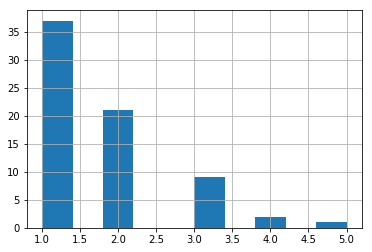

In [19]:
# number of operations per counterparty
txs[txs["tr_type"] == MyTransactionType.DEBIT]["counter_party"].value_counts().hist()

In [20]:
# sample of transactions
txs.head(10)

,transaction_id,entity,tr_type,txn_amount,txn_posted_timestamp,account_id,counter_party,balance_after_posted,sender_country,receiver_country
1,1,HighMark LLC,DEBIT,2737.27,2017-02-10 08:00:00,1,Charles Williams,58786.73,New York,Latvia
2,1553,HighMark LLC,CREDIT,1190.30,2017-02-10 08:00:00,1,June Stanley,59977.03,Kansas,New York
3,1554,HighMark LLC,CREDIT,519.79,2017-02-10 08:00:00,1,Beulah Thompson,60496.82,Minnesota,New York
4,1555,HighMark LLC,CREDIT,2995.24,2017-02-10 08:00:00,1,Donald Schmidt,63492.06,Maine,New York
5,1556,HighMark LLC,CREDIT,587.40,2017-02-11 08:00:00,1,Grace Leonhart,64079.46,Minnesota,New York
6,1557,HighMark LLC,CREDIT,3743.60,2017-02-11 08:00:00,1,Joshua Steele,67823.06,Bulgaria,New York
7,1558,HighMark LLC,CREDIT,4920.05,2017-02-11 08:00:00,1,Evangelina Hallman,72743.11,Sweden,New York
8,1559,HighMark LLC,CREDIT,1331.60,2017-02-11 08:00:00,1,Dawn Goupil,74074.71,Nebraska,New York
9,1560,HighMark LLC,CREDIT,1864.39,2017-02-11 08:00:00,1,Elizabeth Ramos,75939.10,New York,New York
10,1561,HighMark LLC,CREDIT,1730.78,2017-02-11 08:00:00,1,Jamie Vogt,77669.88,Sweden,New York


In [21]:
# sample of debit transactions only
txs[txs["tr_type"] == MyTransactionType.DEBIT].head(5)

,transaction_id,entity,tr_type,txn_amount,txn_posted_timestamp,account_id,counter_party,balance_after_posted,sender_country,receiver_country
1,1,HighMark LLC,DEBIT,2737.27,2017-02-10 08:00:00,1,Charles Williams,58786.73,New York,Latvia
43,43,HighMark LLC,DEBIT,3769.90,2017-02-15 08:00:00,1,Minnie Peyton,134974.66,New York,South Dakota
44,44,HighMark LLC,DEBIT,10682.19,2017-02-15 08:00:00,1,Lynn Ferguson,124292.47,New York,India
46,46,HighMark LLC,DEBIT,7391.46,2017-02-16 08:00:00,1,Donald Torres,119211.74,New York,Washington
47,47,HighMark LLC,DEBIT,2780.32,2017-02-16 08:00:00,1,Samuel Statler,116431.42,New York,Minnesota


In [22]:
# sansactions sent to india
txs[txs["receiver_country"] == "India"]

,transaction_id,entity,tr_type,txn_amount,txn_posted_timestamp,account_id,counter_party,balance_after_posted,sender_country,receiver_country
44,44,HighMark LLC,DEBIT,10682.19,2017-02-15 08:00:00,1,Lynn Ferguson,124292.47,New York,India
55,55,HighMark LLC,DEBIT,12332.15,2017-02-17 08:00:00,1,Lynn Ferguson,99402.17,New York,India
75,75,HighMark LLC,DEBIT,8478.41,2017-02-19 08:00:00,1,Lynn Ferguson,115749.40,New York,India
861,861,HighMark LLC,DEBIT,11782.97,2017-05-21 08:00:00,1,Martha Washington,1129985.20,New York,India
904,904,HighMark LLC,DEBIT,11143.01,2017-05-25 08:00:00,1,Martha Washington,1177770.85,New York,India
923,923,HighMark LLC,DEBIT,12302.96,2017-05-27 08:00:00,1,Martha Washington,1190936.36,New York,India
1389,1389,HighMark LLC,DEBIT,10205.05,2017-07-21 08:00:00,1,Karen Sperry,1755261.00,New York,India
1403,1403,HighMark LLC,DEBIT,10639.37,2017-07-22 08:00:00,1,Karen Sperry,1751912.77,New York,India
1443,1443,HighMark LLC,DEBIT,10408.96,2017-07-27 08:00:00,1,Karen Sperry,1790939.02,New York,India


In [23]:
def make_eff_date(row):
    dt = row.to_pydatetime() + timedelta(days=1)
    return pd.to_datetime(dt)

In [24]:
txs["txn_eff_date"]=txs["txn_posted_timestamp"].apply(make_eff_date)

In [25]:
txs["txn_posted_timestamp"]=txs["txn_posted_timestamp"].dt.date

In [26]:
txs["txn_eff_date"]=txs["txn_eff_date"].dt.date

In [27]:
txs.head(10)

,transaction_id,entity,tr_type,txn_amount,txn_posted_timestamp,account_id,counter_party,balance_after_posted,sender_country,receiver_country,txn_eff_date
1,1,HighMark LLC,DEBIT,2737.27,2017-02-10,1,Charles Williams,58786.73,New York,Latvia,2017-02-11
2,1553,HighMark LLC,CREDIT,1190.30,2017-02-10,1,June Stanley,59977.03,Kansas,New York,2017-02-11
3,1554,HighMark LLC,CREDIT,519.79,2017-02-10,1,Beulah Thompson,60496.82,Minnesota,New York,2017-02-11
4,1555,HighMark LLC,CREDIT,2995.24,2017-02-10,1,Donald Schmidt,63492.06,Maine,New York,2017-02-11
5,1556,HighMark LLC,CREDIT,587.40,2017-02-11,1,Grace Leonhart,64079.46,Minnesota,New York,2017-02-12
6,1557,HighMark LLC,CREDIT,3743.60,2017-02-11,1,Joshua Steele,67823.06,Bulgaria,New York,2017-02-12
7,1558,HighMark LLC,CREDIT,4920.05,2017-02-11,1,Evangelina Hallman,72743.11,Sweden,New York,2017-02-12
8,1559,HighMark LLC,CREDIT,1331.60,2017-02-11,1,Dawn Goupil,74074.71,Nebraska,New York,2017-02-12
9,1560,HighMark LLC,CREDIT,1864.39,2017-02-11,1,Elizabeth Ramos,75939.10,New York,New York,2017-02-12
10,1561,HighMark LLC,CREDIT,1730.78,2017-02-11,1,Jamie Vogt,77669.88,Sweden,New York,2017-02-12


In [28]:
txs[txs["entity"] == "HighMark LLC"].shape

(1552, 11)

In [28]:
# for saving to csv
txs.to_csv("sim1.csv",sep=",",header=True,index=False)

## Which distributions we want to use for credit and debit operations

In [29]:
import seaborn as sns

In [30]:
# First for debit
# max: 20k, min amount: 1.5k, median : 4k

sigma=1
mu=0
ln=scipy.stats.lognorm(s=sigma,scale=np.exp(mu))
# arrc=ln.rvs(size=10000)
arrc = scipy.stats.lognorm.rvs(s=sigma,scale=np.exp(mu),size=10000)
print (pd.Series(arrc*1500).describe())
print ("Median is {}".format(np.median(arrc)))

count    10000.000000
mean      2426.107233
std       3164.493431
min         33.016538
25%        751.943641
50%       1489.452270
75%       2970.658567
max      82894.358283
dtype: float64
Median is 0.992968180249623


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


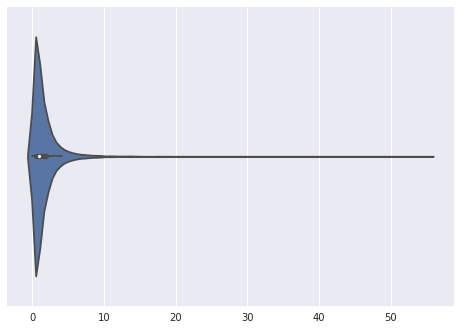

In [31]:
sns.violinplot(arrc)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


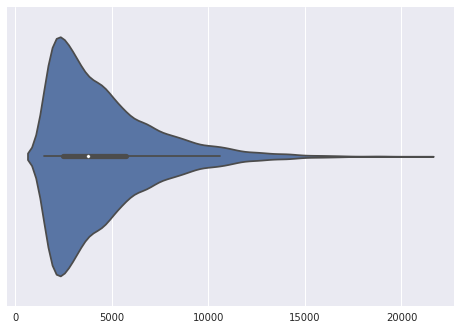

In [32]:
# zatial vyhrava nastavenie 
# arre = scipy.stats.beta.rvs(a=1, b=7, loc=1500, scale=30000, size=10000, random_state=None)
# pripadne
# arre = scipy.stats.beta.rvs(a=1, b=9, loc=1500, scale=30000, size=10000, random_state=None)
bdistr=scipy.stats.beta(a=2,b=5)
# arre=bdistr.rvs(size=10000)
arre = scipy.stats.beta.rvs(a=1, b=9, loc=1500, scale=30000, size=10000, random_state=None)
sns.violinplot(arre)

In [33]:
pd.Series(arre).describe()

count    10000.000000
mean      4515.589228
std       2722.208106
min       1500.394814
25%       2470.831706
50%       3748.360844
75%       5733.416551
max      20786.158989
dtype: float64

In [34]:
np.median(arre)

3748.360843985045

In [35]:
np.percentile(arre,99)

13636.455698893311

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


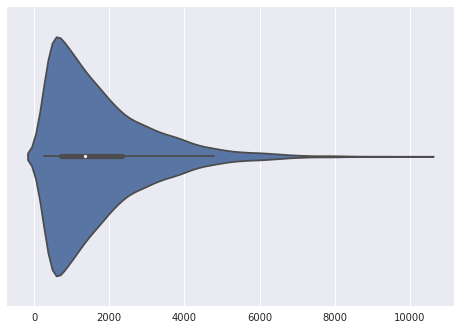

In [36]:
# Second, for credit
# max: 10k, min amount: 250, median : 1k
arrf = scipy.stats.beta.rvs(a=1, b=9, loc=250, scale=15000, size=10000, random_state=None)
sns.violinplot(arrf)

In [37]:
pd.Series(arrf).describe()

count    10000.000000
mean      1737.133677
std       1347.291876
min        250.197777
25%        717.238699
50%       1351.448679
75%       2352.353086
max      10199.678136
dtype: float64

In [38]:
np.median(arrf)

1351.4486786035945

In [39]:
# na pocet agentov
pd.Series(np.random.normal(110,5,size=10)).describe()

count     10.000000
mean     111.002230
std        3.436235
min      105.475725
25%      108.367432
50%      110.956378
75%      113.283470
max      117.085180
dtype: float64